# HW 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans


## Exercise 1

In [2]:
# Read the CSV file
df = pd.read_csv('data_ex1_wt.csv')
print(df.shape)

(27199, 2)


### Problem 1

Draw a scatter plot and verify that there is a trend in the data.

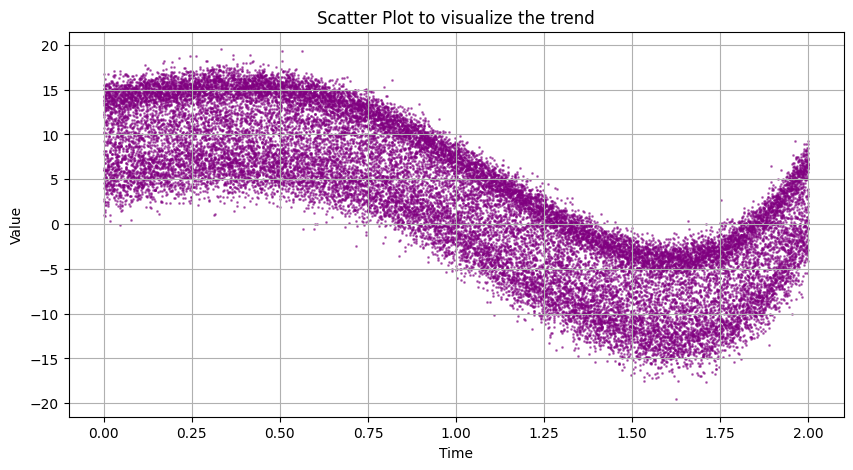

In [3]:
# Display the time series data with a scatter plot

plt.figure(figsize=(10, 5))
plt.scatter(df["time"], df["value"], color="purple", alpha=0.5, s=1)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Scatter Plot to visualize the trend")
plt.show()

In [4]:
def poly_reg(deg, y):
    A = np.vander(t, N=deg + 1, increasing=True)
    b, sq_residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
    y_fit = A @ b
    return y_fit, sq_residuals


### Problem 2

Use least squares to estimate the coefficient of a polynomial trend function, and remove the trend.

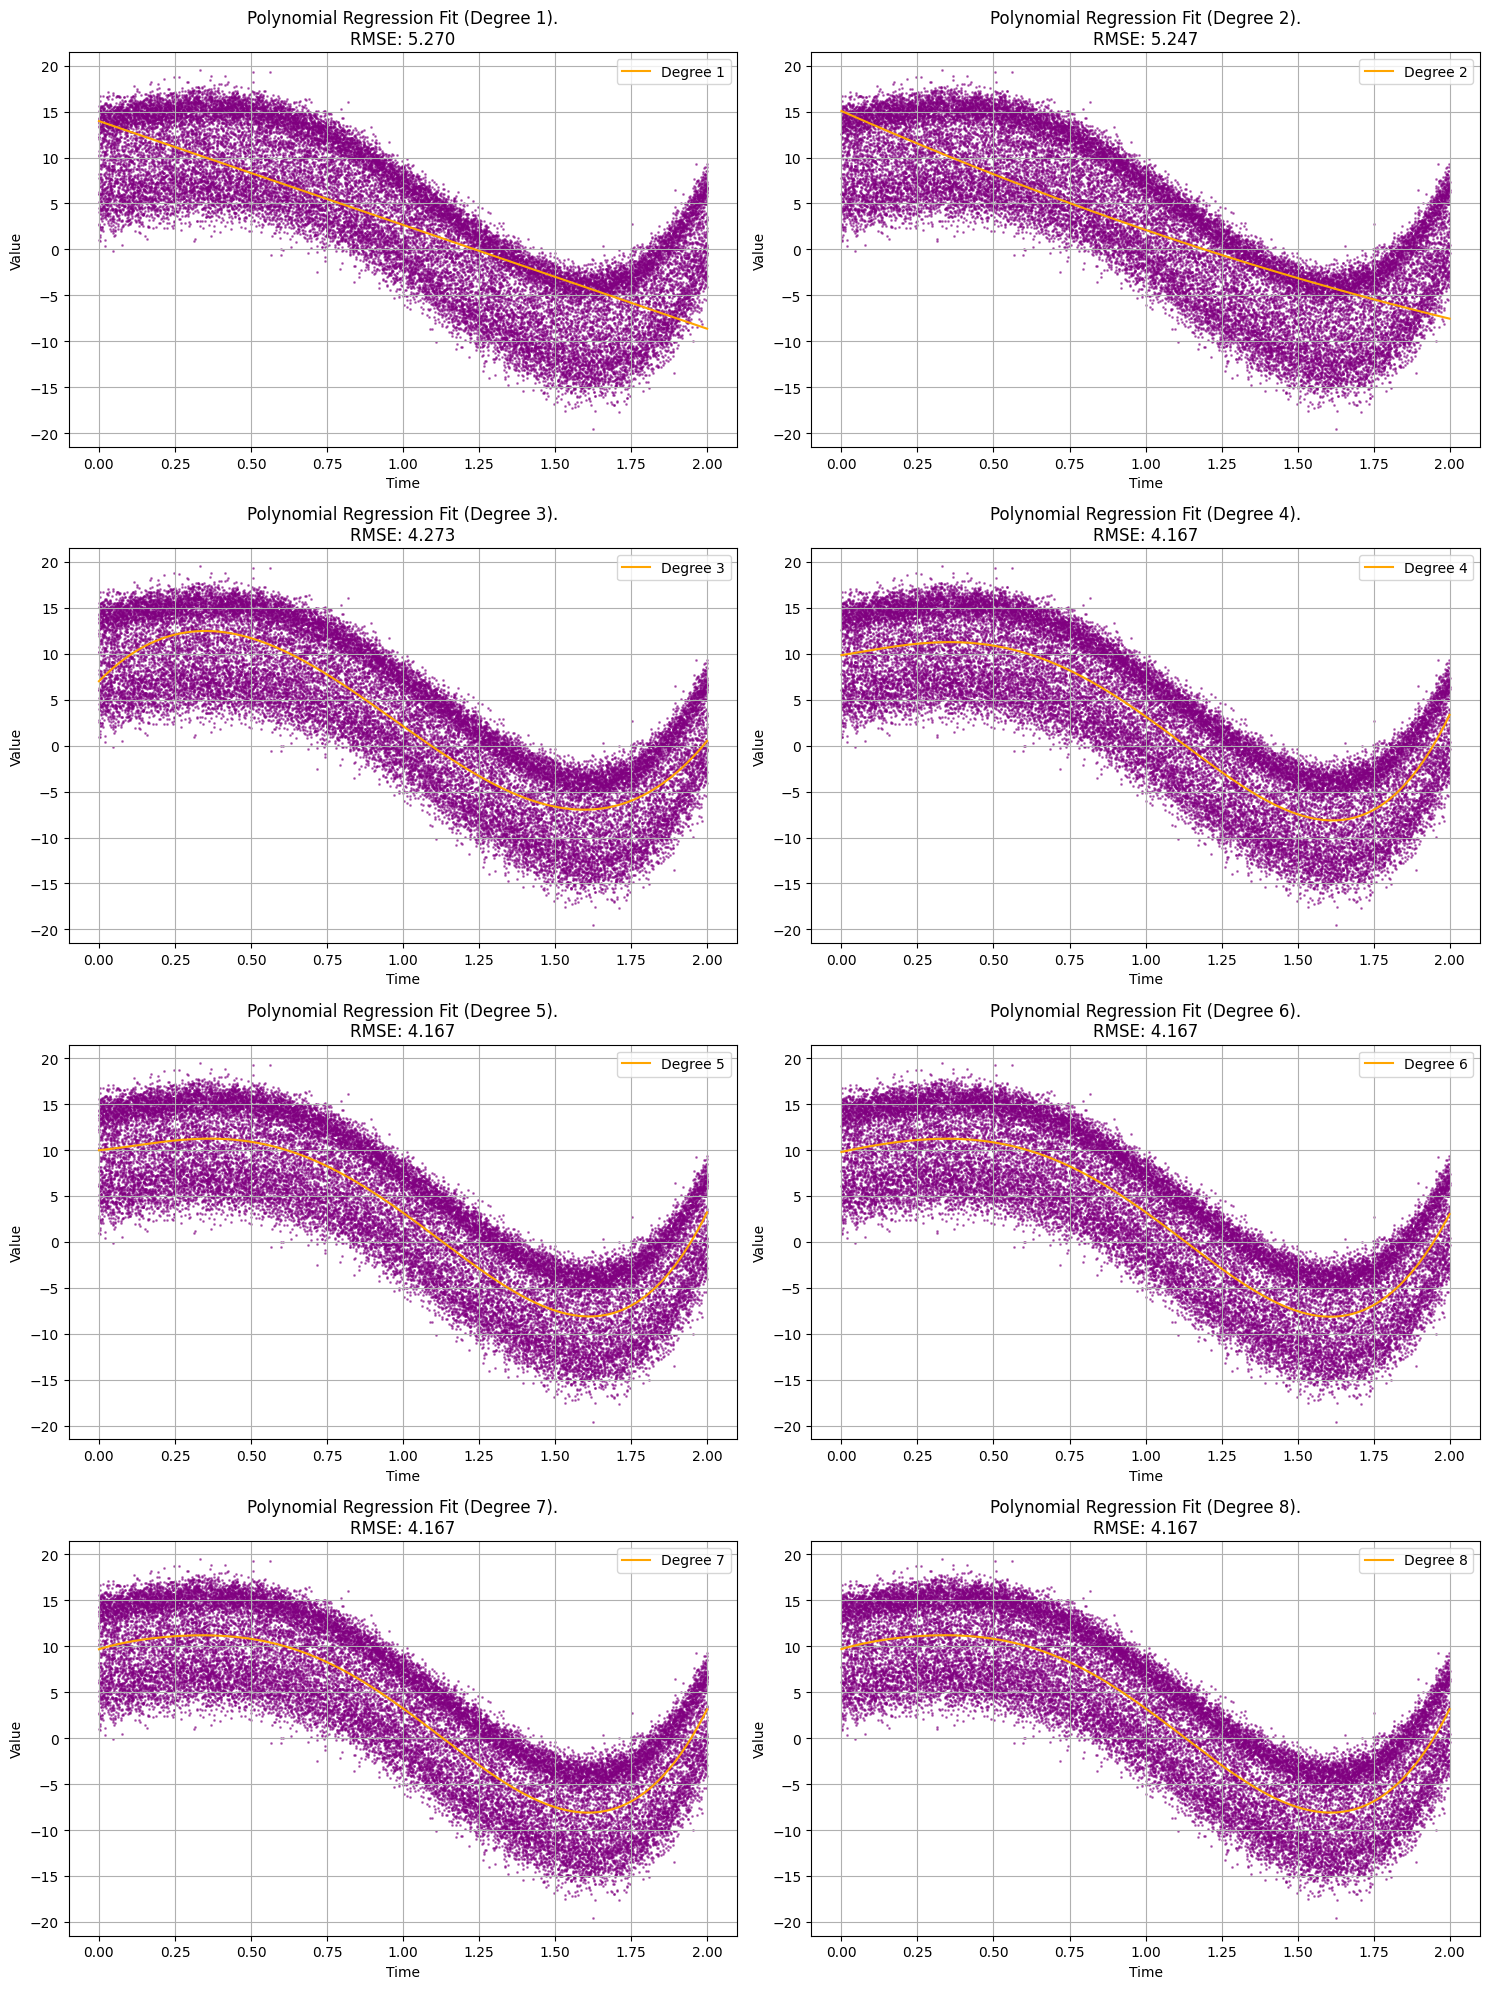

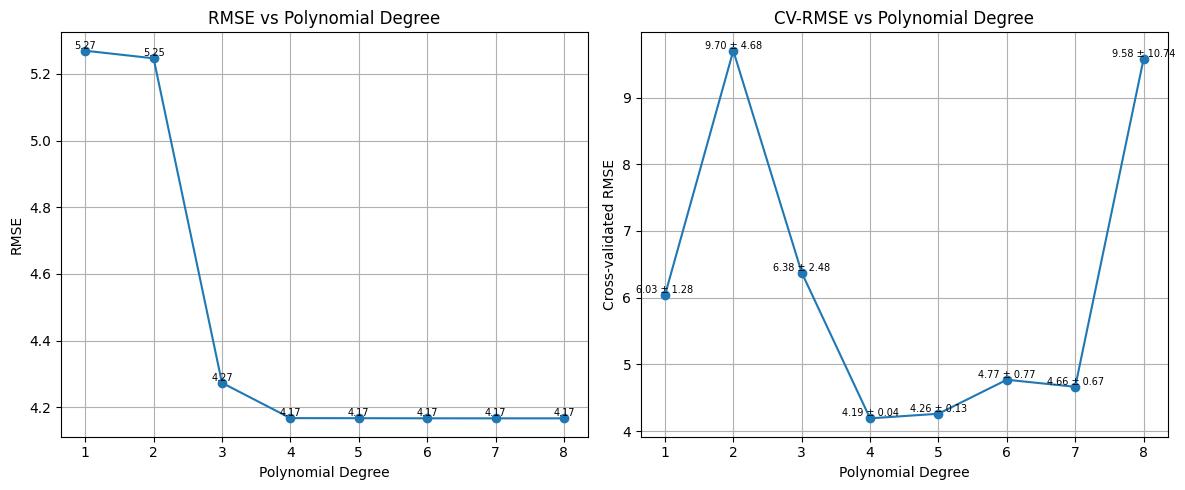

Best model degree:  4


In [5]:
import math

MAX_DEGREE = 8
# Compute the coefficients of polynomial regression from 1 to MAX_DEGREE and plot the results

t = df['time'].values
y = df['value'].values

n_plots = MAX_DEGREE
cols = 2
rows = math.ceil(n_plots / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

rmse_for_degrees = []

for deg in range(1, MAX_DEGREE + 1):
    trend, sq_residuals = poly_reg(deg, y)
    rmse = np.sqrt(sq_residuals / len(y))
    rmse_for_degrees.append(rmse)
    ax = axes[deg-1]
    ax.scatter(t, y, color="purple", alpha=0.5, s=1)
    ax.plot(t, trend, color="orange", label=f"Degree {deg}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_title(f"Polynomial Regression Fit (Degree {deg}).\nRMSE: {float(rmse[0]):.3f}")
    ax.grid()
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

#Using cross validation to confirm the best model in term of generalization

t_cv = df['time'].values.reshape(-1, 1)
y_cv = df['value'].values

degrees = range(1, MAX_DEGREE+1)
rmse_cv = []
rmse_cv_std = []
best_rmse_cv = float('inf')
best_poly = None
#best_model = None

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True, interaction_only=False) #transformer for genearting the  feature matrix (A)
    X_poly = poly.fit_transform(t_cv) # matrix A
    model = LinearRegression()
    # Use negative RMSE and reverse its sign
    scores = -cross_val_score(model, X_poly, y_cv, cv=5, scoring='neg_root_mean_squared_error')
    current_rmse = scores.mean()
    rmse_cv.append(current_rmse)
    rmse_cv_std.append(scores.std())
    if current_rmse < best_rmse_cv:
        best_rmse_cv = current_rmse
        best_poly = poly
        #best_model = model.fit(X_poly, y_cv)

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RMSE vs Polynomial Degree on the second subplot
rmse_floats = [float(r[0]) for r in rmse_for_degrees]
ax1.plot(degrees, rmse_floats, marker='o')
for d, rm in zip(degrees, rmse_floats):
    ax1.text(d, rm, f'{rm:.2f}', ha='center', va='bottom', fontsize=7)
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE vs Polynomial Degree')
ax1.grid(True)

# CV-MSE vs Polynomial Degree on the first subplot
ax2.plot(degrees, rmse_cv, marker='o')
for d_val, cv_rmse, std in zip(degrees, rmse_cv, rmse_cv_std):
    ax2.text(d_val, cv_rmse, f'{cv_rmse:.2f} ± {std:.2f}', ha='center', va='bottom', fontsize=7)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Cross-validated RMSE')
ax2.set_title('CV-RMSE vs Polynomial Degree')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Best model degree: ", best_poly.degree)

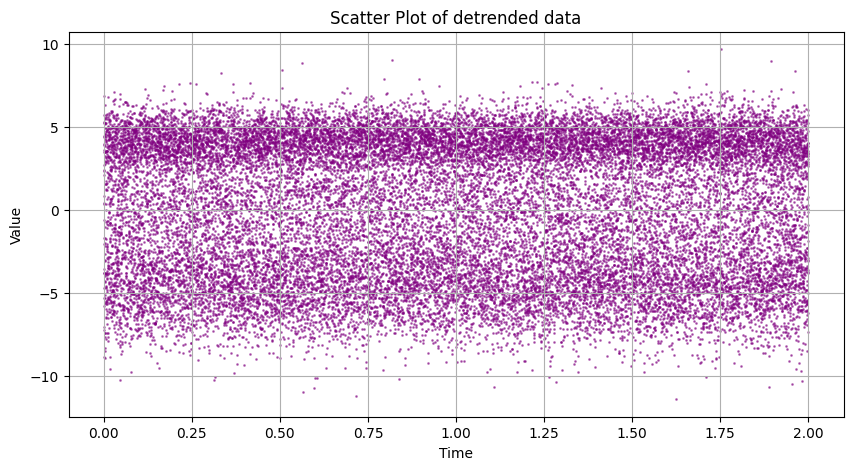

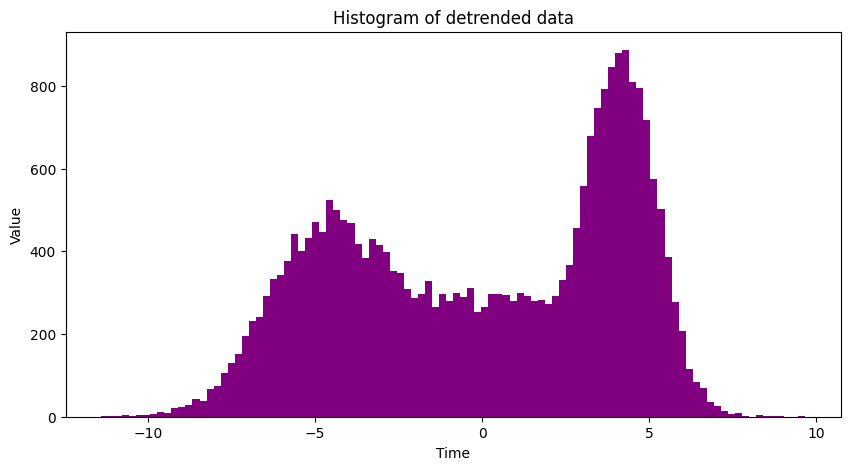

In [6]:
#removing the trend of the data

trend, _ = poly_reg(best_poly.degree, y)

y_detrended = y - trend

plt.figure(figsize=(10, 5))
plt.scatter(df["time"], y_detrended, color="purple", alpha=0.5, s=1)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Scatter Plot of detrended data")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_detrended, color="purple", bins=100)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Histogram of detrended data")
plt.show()




In [7]:
# Gaussian PDF: returns a 1D array
def gaussian_pdf(x, mu, sigma):
    x = np.asarray(x).flatten()
    coef = 1 / np.sqrt(2 * np.pi * sigma**2)
    exponent = np.exp(- (x - mu)**2 / (2 * sigma**2))
    return coef * exponent



def EM(X, K, prior, mu_arr, sigma_arr, max_iter=int(1e9), tol=1e-6):

    N = X.shape[0] # number of samples

    loglikelihood_old = None

    for iteration in range(max_iter):
        # ---- E-step----
        gamma = np.zeros((N, K))
        for k in range(K):
            # weight by prior and likelihood
            gamma[:, k] = prior[k] * gaussian_pdf(X, mu_arr[k], sigma_arr[k])
        # normalize so each row sums to 1
        gamma /= gamma.sum(axis=1, keepdims=True)

        # ---- M-step----
        N_k = gamma.sum(axis=0)
        mu_arr = np.array([(gamma[:, k] * X).sum() / N_k[k] for k in range(K)]) #update means
        sigma_arr = np.array([np.sqrt((gamma[:, k] * (X - mu_arr[k])**2).sum() / N_k[k]) for k in range(K)]) #update std_dev
        prior = N_k / N #update priors

        # ---- Compute log-likelihood ----
        pdfs = np.vstack([prior[k] * gaussian_pdf(X, mu_arr[k], sigma_arr[k])for k in range(K)])  # shape (K, N)

        loglikelihood = np.sum(np.log(pdfs.sum(axis=0)))

        # Check convergence in log-likelihood
        if loglikelihood_old is not None and abs(loglikelihood - loglikelihood_old) < tol:
            break
        loglikelihood_old = loglikelihood

    iteration = iteration if iteration < max_iter else -1
    return prior, mu_arr, sigma_arr, iteration

In [8]:
import numpy as np
from sklearn.cluster import KMeans


# Prepare data: X2d for clustering, X for EM fitting
X2d = y_detrended.reshape(-1, 1)   # 2D array of shape (N, 1) for KMeans
X = X2d.flatten()                  # 1D array of length N for EM computation

K = 3  # number of mixture components

# Initialization via KMeans to get starting means and cluster assignments
kmeans = KMeans(n_clusters=K).fit(X2d)
init_mu_km = kmeans.cluster_centers_.flatten()  # initial means from centroids
labels = kmeans.labels_                      # cluster labels for each sample

init_sigma_km = np.array([(np.sqrt(kmeans.inertia_/np.sum(labels == k))) for k in range(K)]) #estimate variances with the kmeans inertia
init_prior_km = np.array([np.sum(labels == k) for k in range(K)])/X.shape[0]  #prior estimated as the fraction of points in each cluster

# EM algorithm settings
max_iter = int(1e9)
tol = 1e-8

#EM with kmeans initialization
prior_km, mu_km, sigma_km, iteration_km = EM(X, K, init_prior_km, init_mu_km, init_sigma_km)
print("Final parameters with KMeans initialization:")
print(f"Converged at iteration {iteration_km if iteration_km >= 0 else "MAX ITERATIONS REACHED"}")
for k in range(K):
    print(f"Component {k+1}: Weight = {prior_km[k]:.4f}, Mean = {mu_km[k]:.4f}, Var = {sigma_km[k]**2:.4f}")

#EM with random initialization
init_prior_rand = np.ones(K) / K
init_mu_rand = np.random.choice(X, K)
init_sigma_rand = np.full(K, np.std(X))

prior_rand, mu_rand, sigma_rand, iteration_rand = EM(X, K, init_prior_rand, init_mu_rand, init_sigma_rand)

print("---------------------------------------------------------------------------------------")
print("Final parameters with random initialization:")
print(f"Converged at iteration {iteration_rand if iteration_rand >= 0 else "MAX ITERATIONS REACHED"}")
for k in range(K):
    print(f"Component {k+1}: Weight = {prior_rand[k]:.4f}, Mean = {mu_rand[k]:.4f}, Var = {sigma_rand[k]**2:.4f}")



Final parameters with KMeans initialization:
Converged at iteration 334
Component 1: Weight = 0.3534, Mean = 4.2616, Var = 0.9841
Component 2: Weight = 0.3443, Mean = -4.7274, Var = 3.0625
Component 3: Weight = 0.3024, Mean = 0.4021, Var = 5.9683
---------------------------------------------------------------------------------------
Final parameters with random initialization:
Converged at iteration 380
Component 1: Weight = 0.3022, Mean = 0.4040, Var = 5.9641
Component 2: Weight = 0.3534, Mean = 4.2617, Var = 0.9840
Component 3: Weight = 0.3444, Mean = -4.7267, Var = 3.0637


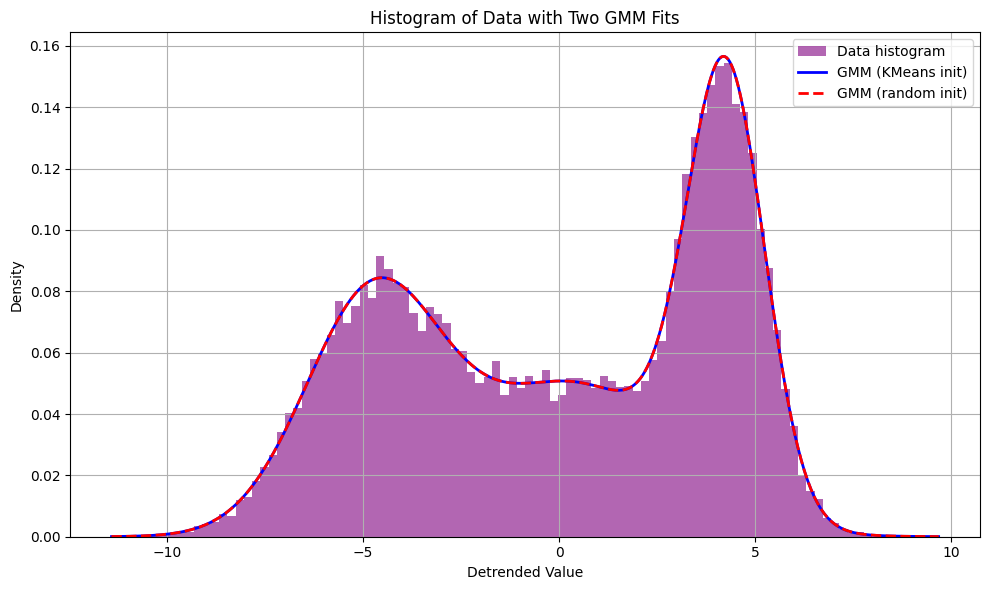

In [9]:
# Create a fine grid over the data range
x_vals = np.linspace(X.min(), X.max(), 500)

# Compute the mixture density for each fitted model
pdf_km   = np.zeros_like(x_vals)
pdf_rand = np.zeros_like(x_vals)
for k in range(K):
    # KMeans‐initialized GMM
    pdf_km   += prior_km[k]   * (1/np.sqrt(2*np.pi*sigma_km[k]**2))   * np.exp(- (x_vals-mu_km[k])**2   /(2*sigma_km[k]**2))
    # Random‐initialized GMM
    pdf_rand += prior_rand[k] * (1/np.sqrt(2*np.pi*sigma_rand[k]**2)) * np.exp(- (x_vals-mu_rand[k])**2 /(2*sigma_rand[k]**2))


plt.figure(figsize=(10,6))
plt.hist( X, bins=100, density=True, alpha=0.6, label='Data histogram', color="purple" )
plt.plot( x_vals, pdf_km,   label='GMM (KMeans init)', linewidth=2, color="blue" )
plt.plot( x_vals, pdf_rand, label='GMM (random init)', linestyle='--', linewidth=2, color="red" )
plt.xlabel('Detrended Value')
plt.ylabel('Density')
plt.title('Histogram of Data with Two GMM Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()